## Create dataloader

In [9]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
from data_loader import MyDataset
from torch.utils.data import DataLoader
from models.unet import UNet, PretrainedUNet, output_maps

In [162]:
labels_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/labels.npy"
images_path = "/Users/ngandige/Documents/stardist/StarDist-Lizard/data/images.npy"
dataset = MyDataset(images_path, labels_path)
dataset_size = len(dataset)
print(dataset_size)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

4981


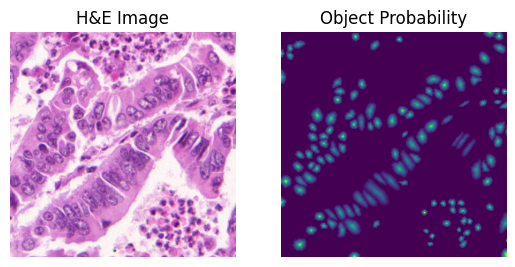

In [179]:
test_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1)
data = next(iter(test_loader))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('H&E Image')  
plt.imshow(data[0][0].permute(1,2,0))
plt.subplot(1,2,2)
plt.axis('off')
plt.title('Object Probability') 
plt.imshow(data[1][0])
plt.show()


In [180]:
data[0].shape, data[1].shape, data[2].shape

(torch.Size([2, 3, 256, 256]),
 torch.Size([2, 256, 256]),
 torch.Size([2, 8, 256, 256]))

In [168]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(3).to(device)
model1 = output_maps().to(device)

In [181]:
#Hyperparameters taken from paper:
batch_size = 2
lr = 0.0003
num_epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss1 = torch.nn.BCEWithLogitsLoss()
loss2 = torch.nn.MSELoss(reduction='none')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training loop

In [186]:
obj_prob_loss_epoch = []
dist_loss_epoch = []
num_batches = len(train_loader)
for epoch in range(num_epochs):
    obj_prob_running_loss = 0.0
    dist_running_loss = 0.0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        images, object_probabilities, star_poly_dist = data
        images, object_probabilities, star_poly_dist = images.to(device), object_probabilities.to(device), star_poly_dist.to(device)
        outputs = model(images)
        pred_prob, pred_dist = model1(outputs)
        # pdb.set_trace()
        obj_prob_loss = loss1(pred_prob.squeeze(1), object_probabilities)
        dist_loss = torch.mean(loss2(pred_dist, star_poly_dist) * object_probabilities.unsqueeze(1))
        loss = obj_prob_loss + dist_loss
        loss.backward()
        optimizer.step()
        obj_prob_running_loss += obj_prob_loss.item()
        dist_running_loss += dist_loss.item()
    obj_prob_loss_epoch.append(obj_prob_running_loss/num_batches)
    dist_loss_epoch.append(dist_running_loss/num_batches)
    print("Epoch: {}, Object Probability Loss: {}, Distance Loss: {}, Loss: {}".format(epoch, obj_prob_loss_epoch[-1], dist_loss_epoch[-1], loss.item()))


In [1]:

import os
os.cpu_count()

16

In [22]:
data_inputs = np.random.randn(5000, 5000)

In [28]:
from multiprocessing import Pool
import time
from test_multiprocess import process_image


if __name__ == '__main__':
    pool = Pool(2)                         # Create a multiprocessing Pool
    start = time.time()
    pool.map(process_image, (data_inputs,))  #
    end = time.time()
    print("Time taken = {}".format(end - start))

Time taken = 10.800733804702759


In [24]:
def process_image(data_inputs):
    for i in range(5000):
        for j in range(5000):
            data_inputs[i][j] = data_inputs[i][j] * 2

if __name__ == '__main__':
    start = time.time()
    process_image(data_inputs)
    end = time.time()
    print("Time taken = {}".format(end - start))

Time taken = 10.41944408416748


In [1]:
if [ ! -e $(python -c 'from distutils.sysconfig import get_makefile_filename as m; print m()') ]; then echo "Sorry"; fi


SyntaxError: invalid syntax (1745580068.py, line 1)